### Description: Sparse Bayesian learning
#### Assumptions: scalar input, scalar output

###### Author: Rimple Sandhu, Carleton University; Email: rimple_sandhu@outlook.com

In [1]:
#!/usr/bin/python
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import os, math, sys

Assign polynomial basis (polyPower), hyper-parameters a,b,c,d and initial hyperparameter $\alpha$ and noise precision $\rho$:

In [2]:
polyPower = [0,1,2,3,4,5] # powers of polynomial basis
N = len(polyPower) # number of coefficients 
rho0 = 100 # initial error precision
alpha0 = [1e-04]*N # initial hyperparameter vector
Wlim = [-5,5]
Nsbl = 200
a = 1e-04
b = 1e-04
c = 1e-04
d = 1e-04

Generate design matrix $\Phi$, and load observations $Y$ and input $X$: 

In [3]:
def PhiMat(X):
    M = len(X)
    Phi = np.zeros((M,N))
    for i in range(0,M):
        for j in range(0,N):
            Phi[i,j] = X[i]**polyPower[j]
    return Phi
Yobs = np.loadtxt('Ydata.dat') 
Xobs = np.loadtxt('Xdata.dat')
Phi = PhiMat(Xobs)
M = len(Yobs)

Sparse Bayesian leanring through Mackay's algorithm (similar to expectation maximizations):

In [4]:
def getEvid(alp,rh):
    return st.multivariate_normal.pdf(Yobs,[0]*M,np.matmul(Phi,np.matmul(np.linalg.inv(np.diag(alp)),np.transpose(Phi))) + np.identity(M)/rh)

def updatemP(alphai,rhoi):
    A = np.diag(alphai)
    Pi = np.linalg.inv(A + rhoi*np.matmul(np.transpose(Phi),Phi))
    mi = np.matmul(Pi,rhoi*np.matmul(np.transpose(Phi),Yobs))
    evidi = getEvid(alphai,rhoi)
    return mi, Pi, evidi

Run the sparse Bayesain learning loop to obtain optimal hyperparameter:

In [5]:
Ngrid = 1000
Wpost = np.zeros((N,Ngrid))
Wprior = np.zeros((N,Ngrid))
Wgrid = np.zeros((N,Ngrid))
alpha = np.zeros((N,Nsbl))
Wvar = np.zeros((N,Nsbl))
Wmu = np.zeros((N,Nsbl))
KLdis = np.zeros((N,Nsbl))
gam = np.zeros((N,Nsbl))
evid = [0]*Nsbl
gof = [0]*Nsbl
rho = [0]*Nsbl
Wrange=np.zeros((N,2))
alpha[:,0] = alpha0;
rho[0] = rho0;
for j in range(0,Nsbl-1):
    Wmu[:,j],P,evid[j] = updatemP(alpha[:,j],rho[j])
    Wvar[:,j] = np.diag(P)
    for i in range(0,N):
        gam[i,j] = 1 - alpha[i,j]*P[i,i]
        alpha[i,j+1] = (gam[i,j] + 2*a)/((Wmu[i,j]**2)+2*b)
        if j == 1:
            Wrange[i,1] = max(3/np.sqrt(alpha[i,j]),Wmu[i,j]+3*np.sqrt(Wvar[i,j]))
            Wrange[i,0] = min(-3/np.sqrt(alpha[i,j]),Wmu[i,j]-3*np.sqrt(Wvar[i,j]))
        Wgrid[i,:] = np.linspace(Wrange[i,0],Wrange[i,1],Ngrid)
        Wgrid[i,:] = np.linspace(Wlim[0],Wlim[1],Ngrid)
        Wpost[i,:] = st.multivariate_normal.pdf(Wgrid[i,:],Wmu[i,j],Wvar[i,j])
        Wprior[i,:] = st.multivariate_normal.pdf(Wgrid[i,:],0,1/alpha[i,j])
        KLdis[i,j] = st.entropy(Wpost[i,:],Wprior[i,:]) 
    rho[j+1] = (M - np.sum(gam[:,j]) + 2*c)/(np.power(np.linalg.norm(Yobs-np.matmul(Phi,Wmu[:,j])),2)+2*d)
    gof[j] = st.multivariate_normal.pdf(Yobs,np.matmul(Phi,Wmu[:,j]),np.identity(M)/rho[j])
    #print(alpha[:,j],rho[j], np.log(evid[j]),gof[j])

## Plotting for SBL iteration

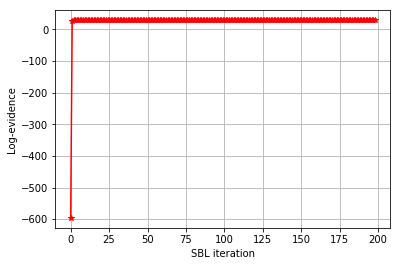

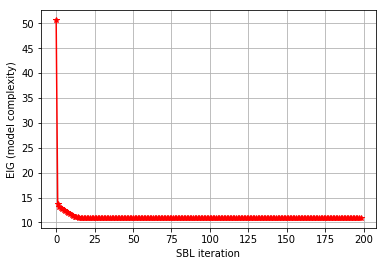

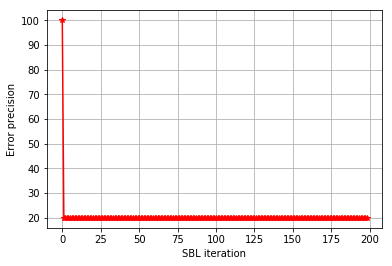

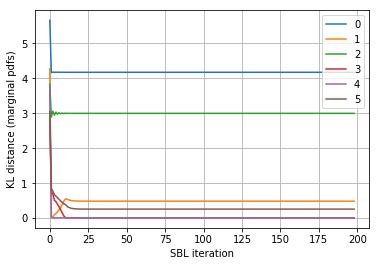

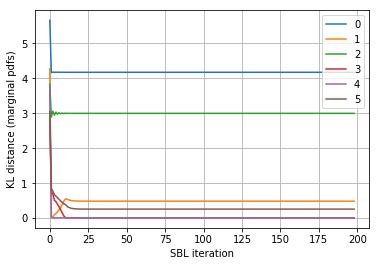

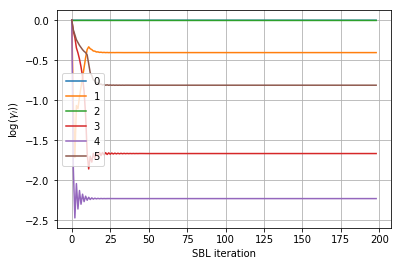

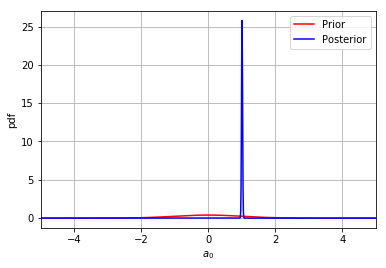

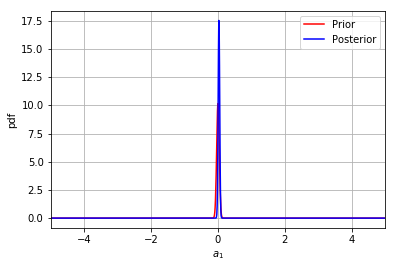

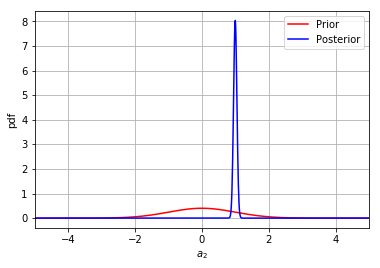

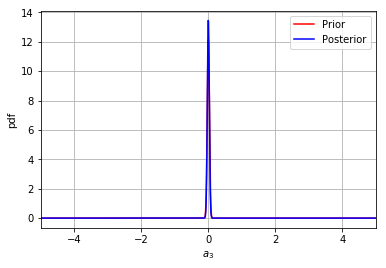

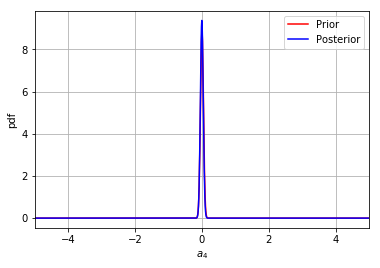

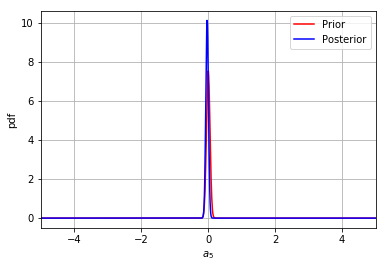

In [6]:
plt.figure(1)
plt.plot(np.log(evid[:-1]),'r*')
plt.plot(np.log(evid[:-1]),'r-')
plt.grid(True)
plt.ylabel('Log-evidence')
plt.xlabel('SBL iteration'); 
plt.savefig('SBL_EVID.eps',bbox_inches='tight')
plt.figure(2)
plt.plot(np.log(gof[:-1]) - np.log(evid[:-1]),'r*')
plt.plot(np.log(gof[:-1]) - np.log(evid[:-1]),'r-')
plt.grid(True)
plt.ylabel('EIG (model complexity)')
plt.xlabel('SBL iteration'); 
plt.savefig('SBL_EIG.eps',bbox_inches='tight')
plt.figure(3)
plt.plot(rho[:-1],'r*')
plt.plot(rho[:-1],'r-')
plt.grid(True)
plt.ylabel('Error precision')
plt.xlabel('SBL iteration');
plt.savefig('SBL_RHO.eps',bbox_inches='tight')
plt.figure(4)
for i in range(0,N):
    plt.plot(KLdis[i,:-1],label=str(i))
plt.grid(True)
plt.ylabel('KL distance (marginal pdfs)')
plt.xlabel('SBL iteration')
plt.legend(loc='best', numpoints = 1);
plt.savefig('SBL_KLDIV.eps',bbox_inches='tight')
plt.figure(5)
for i in range(0,N):
    plt.plot(KLdis[i,:-1],label=str(i))
plt.grid(True)
plt.ylabel('KL distance (marginal pdfs)')
plt.xlabel('SBL iteration')
plt.legend(loc='best', numpoints = 1);
plt.savefig('SBL_KLDIV.eps',bbox_inches='tight')
plt.figure(6)
for i in range(0,N):
    plt.plot(np.log(gam[i,:-1]),label=str(i))
plt.grid(True)
plt.ylabel(r'$\log(\gamma_i)$)')
plt.xlabel('SBL iteration')
plt.legend(loc='best', numpoints = 1);
plt.savefig('SBL_GAMMA.eps',bbox_inches='tight')
for i in range(0,N):
    fig = plt.figure(7+i)
    plt.plot(Wgrid[i,:],Wprior[i,:],'r-',label='Prior')
    plt.plot(Wgrid[i,:],Wpost[i,:],'b-',label='Posterior')
    plt.grid(True)
    plt.xlabel(r'$a_'+str(i)+'$')
    plt.ylabel('pdf')
    #plt.xlim(Wrange[i,:])
    plt.xlim(Wlim[0],Wlim[1])
    plt.legend(loc='best', numpoints = 1)
    plt.savefig('BLR_PDF_W'+str(i)+'.eps',bbox_inches='tight')

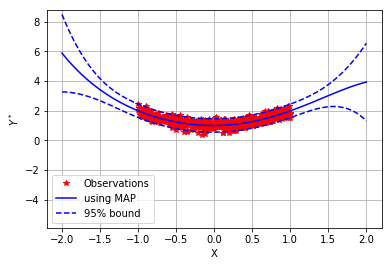

In [7]:
Mnew = 100
Xextra = 1
Xnew = np.linspace(min(Xobs)-Xextra,max(Xobs)+Xextra,Mnew)
PhiNew = PhiMat(Xnew)
PredVar = np.matmul(PhiNew,np.matmul(P,np.transpose(PhiNew))) + np.identity(Mnew)/rho[Nsbl-2]
PredMean = np.matmul(PhiNew,Wmu[:,Nsbl-2])
fig = plt.figure(N+8)
plt.plot(Xobs,Yobs,'r*',label='Observations')
plt.plot(Xnew,PredMean,'b-',label='using MAP')
plt.plot(Xnew,PredMean+2*np.sqrt(np.diag(PredVar)),'b--',label='95% bound')
plt.plot(Xnew,PredMean-2*np.sqrt(np.diag(PredVar)),'b--')
plt.grid(True)
plt.ylim([min(Yobs)-3*abs(max(Yobs)-min(Yobs)),max(Yobs)+3*abs(max(Yobs)-min(Yobs))])
plt.ylabel(r'$Y^*$')
plt.xlabel('X')
plt.legend(loc='best', numpoints = 1)
plt.savefig('SBL_PRED.eps',bbox_inches='tight')
